In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [40]:
TRAIN_DIR = '/Users/vinayakpahalwan/Downloads/train'
TEST_DIR = '/Users/vinayakpahalwan/Downloads/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR,'6conv')

In [41]:
def label_img(img):
    word_label=img.split('.')[-3]
    if word_label == 'cat' : return [1,0]
    elif word_label == 'dog' : return [0,1]

In [42]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [43]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [44]:
train_data = create_train_data()

100%|██████████| 25000/25000 [01:45<00:00, 237.35it/s]


In [60]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [61]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /Users/vinayakpahalwan/dogsvscats-0.001-6conv.model
model loaded!


In [62]:
train = train_data[:-600]
test = train_data[-400:]

In [63]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [64]:
model.fit({'input': X}, {'targets': Y}, n_epoch=9, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 4586  | total loss: 0.32323 | time: 84.207s
| Adam | epoch: 009 | loss: 0.32323 - acc: 0.8544 -- iter: 24384/24400
Training Step: 4587  | total loss: 0.32713 | time: 85.431s
| Adam | epoch: 009 | loss: 0.32713 - acc: 0.8502 | val_loss: 0.49778 - val_acc: 0.7850 -- iter: 24400/24400
--


In [65]:
#Accuracy: 85%
model.save(MODEL_NAME)

INFO:tensorflow:/Users/vinayakpahalwan/dogsvscats-0.001-6conv.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:35<00:00, 352.79it/s]


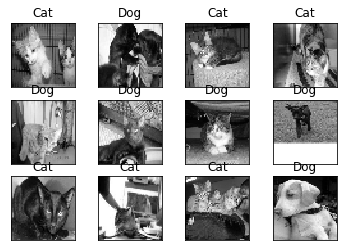

In [66]:
import matplotlib.pyplot as plt

test_data = process_test_data()

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()